# Example interpolation for aare iworid paper

- Support material for the iworid praper: [insert DOI]
- Cluster data is available on: http://doi.psi.ch/detail/10.16907\%2F60d8d58e-cad2-4c5c-b2a6-aa3cdac43ce0
- The aim of this notebook is to give the reader an insight in how to run the interpolation from aare
- It includes several visualization steps that are not strictly neccesary but can help understanding
- The aim is not to provide the shortest, most concise way of analysing image data but rather to give the user a starting point
- Analysis run with: aare **2025.8.22**

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import time

import boost_histogram as bh  #we use boost_histogram for storing ETA values and images
import pickle                 #needed to save boost-histograms
import aare

#Where is the data?
base = Path('/home/l_msdetect/erik/tmp/bee/bee')
ff_fname = base/'Bees_head_flat_10.clust'
cluster_fname= base/'Bees_head_10.clust'

#Save histograms to be able to rerun part of the workflow
eta_fname = "/home/l_msdetect/erik/tmp/eta_hist_bee.pkl"
ff_hist_fname = "/home/l_msdetect/erik/tmp/ff_hist_bee.pkl"
ff_hitmap_hist_fname = "/home/l_msdetect/erik/tmp/ff_hitmap_hist_bee.pkl"
img_hist_fname = "/home/l_msdetect/erik/tmp/img_hist_bee.pkl"
img_hitmap_hist_fname = "/home/l_msdetect/erik/tmp/img_hitmap_hist_bee.pkl"

#General  configuration
gain = 155               #ADU/keV default calibration for Moench03
chunk_size = 1_000_000   #number of clusters to load at a time
n_chunks = 1000           #How many chunks to process, saves time when playing with parameters
clim = np.array((0,100)) #Color scale for the images to plot. Related to how many clusters we process

## Fill a 3D histogram with the ETA values

- For polychromatic data we use a 3D histogram with x, y, energy since ETA depends on energy

File has up to: 4940 chunks
chunk: 999/1000
Processing eta took: 79.170s


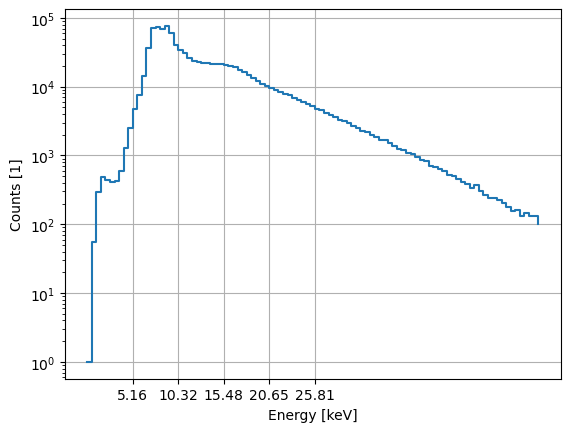

In [2]:
#Process data to make a new eta histogram, if false we load eta from disk
make_eta = True

#Save the processed eta. Useful to disable in case we reprocess with low stats
save_eta = False

#configure the eta histogram
n_bins = 400
ax_min = -0.2
ax_max = 1.2
e_min = 800  #DACu
e_max = 4000 #DACu
e_bins = 4


#Estimate how many clusters there are in the file
forecase_chunks = ff_fname.stat().st_size/40/chunk_size
print(f'File has up to: {forecase_chunks:.0f} chunks')

#Histogram to hold the ETA value per energy bin
hist = bh.Histogram(
    bh.axis.Regular(n_bins, ax_min, ax_max), 
    bh.axis.Regular(n_bins, ax_min, ax_max),
    bh.axis.Regular(e_bins, e_min, e_max),
)

#ROI for reading clusters, excluding sensor borders
roi = aare.ROI(xmin = 10, xmax = 390, ymin = 10, ymax = 390)
ebins = np.array(hist.axes.edges.T[2].flat)

first = True
if make_eta:
    t0 = time.perf_counter()
    with aare.ClusterFile(ff_fname) as f:
        f.set_roi(roi)
        for i in range(n_chunks):
            clusters = f.read_clusters(chunk_size)
            if clusters.size == 0:
                print(f'EOF reached')
                break

            #Calculate eta for the 2x2 cluster and store in a 3D histogram
            eta2 = aare.calculate_eta2(clusters)
            energy = clusters.sum_2x2()
            hist.fill(eta2[:,0], eta2[:,1], energy)

            #Make a histogram for the first chunk we read to visualize
            #the spectrum of the clusters. No need to add all clusters to this histogram.
            if first:
                first = False
                hist2 = bh.Histogram(
                    bh.axis.Regular(100, 0, 8000)
                )
                hist2.fill(clusters.sum_2x2())
                m = hist2.values().max()
                fig, ax = plt.subplots()
                ax.step(hist2.axes[0].edges[:-1]/gain, hist2.values(), where="post");
                ax.set_xticks(hist.axes[2].edges/gain)
                ax.grid()
                ax.set_yscale('log')
                ax.set_xlabel('Energy [keV]')
                ax.set_ylabel('Counts [1]')
            print(f'chunk: {i}/{n_chunks}', end = '\r')
    print()

    t_elapsed = time.perf_counter()-t0
    print(f'Processing eta took: {t_elapsed:.3f}s')
    if save_eta:
        with open(eta_fname, "wb") as f:
            pickle.dump(hist, f)
else:
    #No reprocessing of the eta, just load the histogram
    with open(eta_fname, "rb") as f:
        hist = pickle.load(f)

## Visualize ETA and create Interpolator

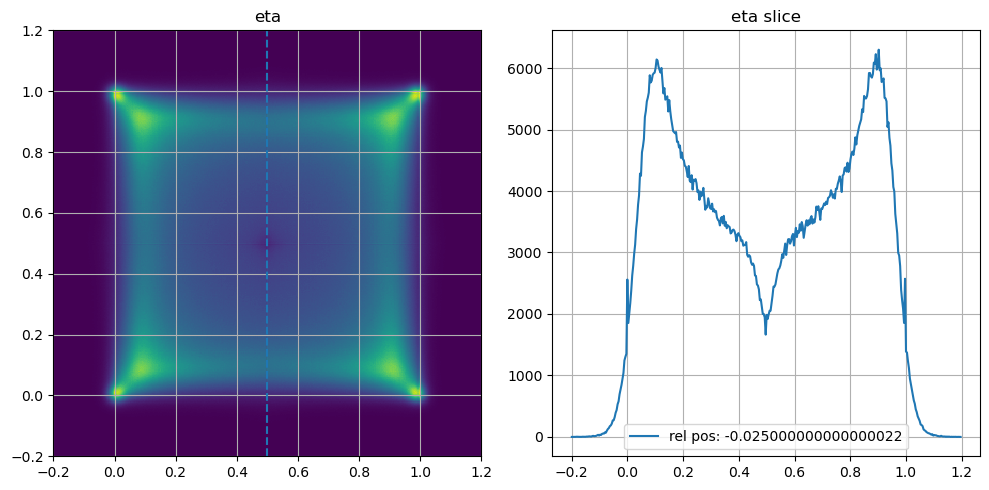

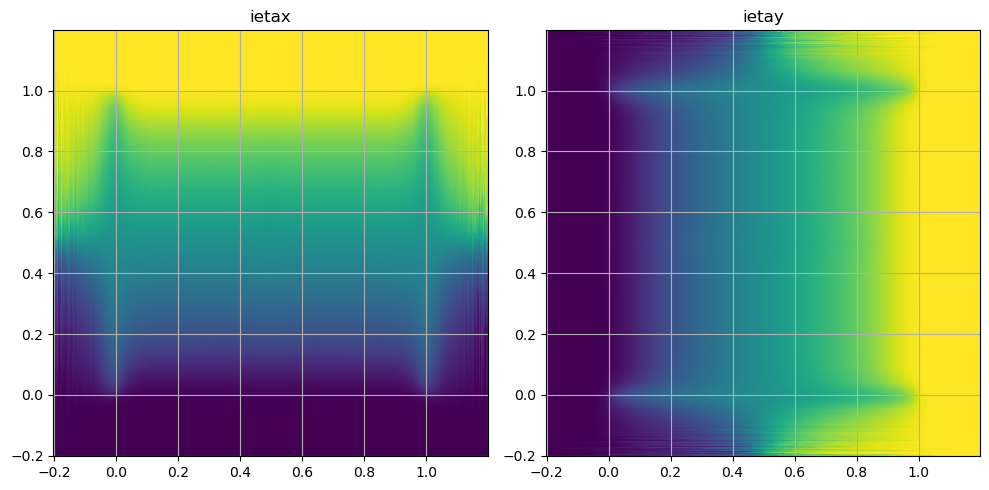

In [3]:
vis_index = 0     #Which energy bin should we visualize?
x_index = 200     #For the line profile which column to use
plot_prep = True  #Plot results
 

eta = hist.view().copy()
etabinsx = np.array(hist.axes.edges.T[0].flat)
etabinsy = np.array(hist.axes.edges.T[1].flat)
ebins = np.array(hist.axes.edges.T[2].flat)
x_pos = etabinsx[x_index]

if plot_prep:
    fig, axs = plt.subplots(1,2, figsize = (10,5))
    axs[0].pcolormesh(etabinsx[:-1], etabinsy[:-1], eta[:,:,vis_index])
    axs[0].set_xlim(-0.2,1.2)
    axs[0].set_ylim(-0.2,1.2)
    axs[0].set_title('eta')
    axs[0].plot([x_pos,x_pos], [-0.2,1.2], '--')
    axs[1].plot(etabinsx[:-1], eta[:,x_index, vis_index], label = f'rel pos: {etabinsx[50]}')
    axs[1].set_title('eta slice')
    axs[1].legend()
    for ax in axs:
        ax.grid()
    fig.tight_layout()

#We create the interpolator object here since it does the preparation of the 
#etax/y that we want to plot
p = aare.Interpolator(eta, etabinsx[:-1], etabinsy[:-1], ebins[:-1]) 


if plot_prep:
    ietax=p.get_ietax()
    ietay=p.get_ietay()
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].pcolormesh(etabinsx[:-1], etabinsy[:-1],ietax[:,:,vis_index])
    axs[1].pcolormesh(etabinsx[:-1], etabinsy[:-1],ietay[:,:,vis_index])
    axs[0].set_title('ietax')
    axs[1].set_title('ietay')
    for ax in axs:
        ax.grid()
    fig.tight_layout()



## Flatfield

Process the flatfield data (beam without object), creating the interpolated image and a hitmap with the native pixel size.

In [4]:
#Create a new flatfield from data instead of loading
make_flatfield = True

#Configure the image. We interpolate to 2000 bins in x and y (5x5um2)
n_bins = 2000
xmin = 0
xmax = 400
scale = n_bins**2/(xmax-xmin)**2 #Scale factor for color map when plotting interpolated images


forecase_chunks = ff_fname.stat().st_size/40/chunk_size
print(f'Flatfield file has up to: {forecase_chunks:.0f} chunks')

if make_flatfield:
    t0 = time.perf_counter()

    #Histogram for interpolated image
    hist = bh.Histogram(
        bh.axis.Regular(n_bins, xmin, xmax), 
        bh.axis.Regular(n_bins, xmin, xmax),
        bh.axis.Regular(e_bins, e_min, e_max)
    )

    #Histogram for hitmap (native pixel size)
    hit_hist = bh.Histogram(
        bh.axis.Regular(400, 0-.5, 400-.5), 
        bh.axis.Regular(400, 0-.5, 400-.5),
        bh.axis.Regular(e_bins, e_min, e_max)
    )


    # hm = np.zeros((400,400))
    i = 0
    with aare.ClusterFile(ff_fname, chunk_size = chunk_size) as f:
        for clusters in f:
            photons = p.interpolate(clusters) #Interpolate the photon position
            arr = np.array(clusters, copy=False)
            hist.fill(photons['y'], photons['x'], photons['energy'])
            hit_hist.fill(arr['y'], arr['x'], clusters.sum_2x2())
            i+=1
            if i==n_chunks:
                break
            print(f'chunk: {i}/{n_chunks}', end = '\r')

    #Save histograms 
    with open(ff_hist_fname, "wb") as f:
        pickle.dump(hist, f)   
    with open(ff_hitmap_hist_fname, "wb") as f:
        pickle.dump(hit_hist, f) 
    t_elapsed = time.perf_counter()-t0
    print(f'Processed flatfiled in {t_elapsed:.3f}s')
else:
    #Load the previous processed histograms
    with open(ff_hist_fname, "rb") as f:
        hist = pickle.load(f)
    with open(ff_hitmap_hist_fname, "rb") as f:
        hit_hist = pickle.load(f)


ff_hitmap = hit_hist.view().copy()
flatfield = hist.view().copy()

Flatfield file has up to: 4940 chunks
Processed flatfiled in 259.347s


### Visualize flatfield

Text(0.5, 1.0, 'Hitmap - flatfield[:, : 2]')

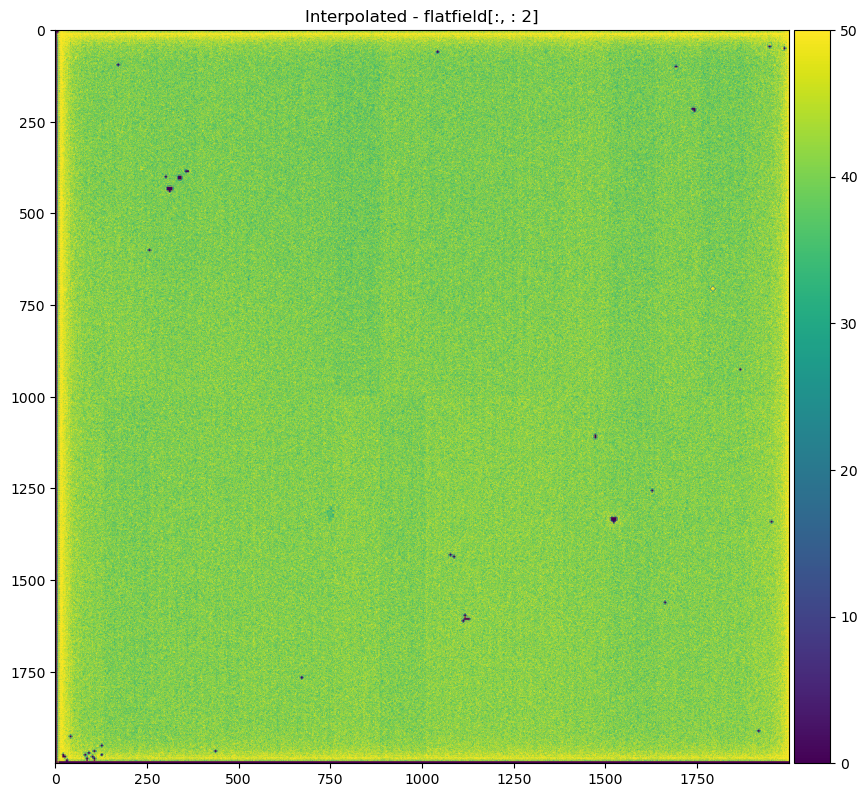

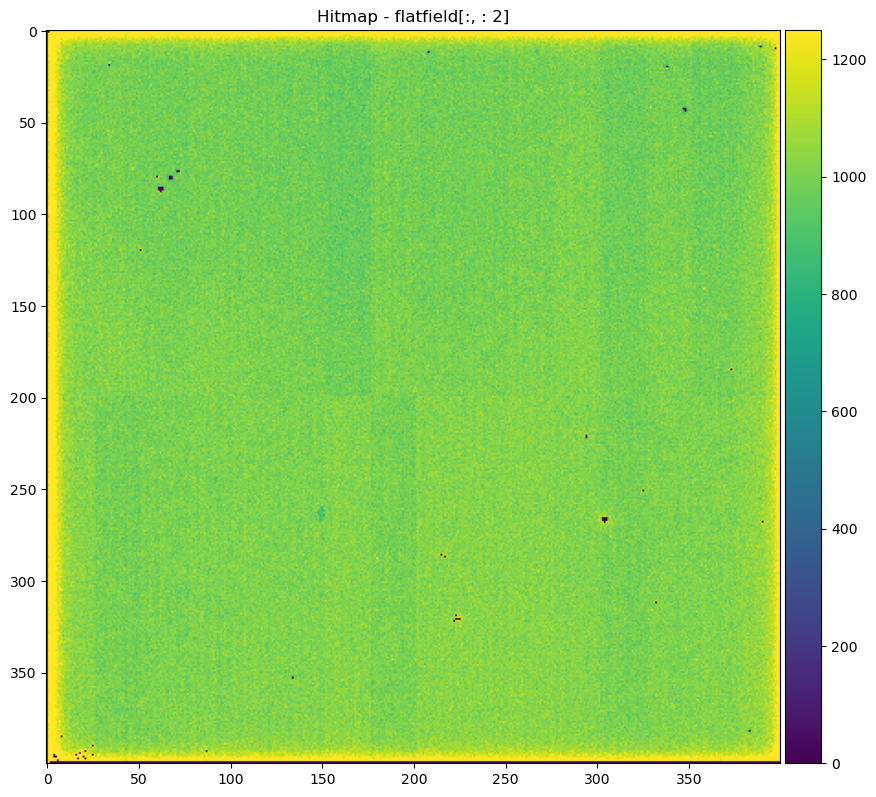

In [21]:
vis_index = 2
clim = np.array((0,50))
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(flatfield[:,:,vis_index])
im.set_clim(clim)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title(f'Interpolated - flatfield[:, : {vis_index}]')

fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(ff_hitmap[:,:,vis_index])

im.set_clim(clim*scale)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title(f'Hitmap - flatfield[:, : {vis_index}]')

In [6]:
make_image = True


forecase_chunks = cluster_fname.stat().st_size/40/chunk_size
print(f'File has up to: {forecase_chunks:.0f} chunks')


if make_image:
    t0 = time.perf_counter()
    hist = bh.Histogram(
        bh.axis.Regular(n_bins, xmin, xmax), 
        bh.axis.Regular(n_bins, xmin, xmax),
        bh.axis.Regular(e_bins, e_min, e_max)
    )


    hit_hist = bh.Histogram(
        bh.axis.Regular(400, 0-.5, 400-.5), 
        bh.axis.Regular(400, 0-.5, 400-.5),
        bh.axis.Regular(e_bins, e_min, e_max)
    )
    i = 0
    with aare.ClusterFile(cluster_fname, chunk_size = chunk_size ) as f:
        for clusters in f:
            photons = p.interpolate(clusters)
            arr = np.array(clusters, copy=False)
            hit_hist.fill(arr['y'], arr['x'], clusters.sum_2x2())
            hist.fill(photons['y'], photons['x'], photons['energy'])
            i+=1
            if i==n_chunks:
                break
            print(f'chunk: {i}/{n_chunks}', end = '\r')

    
    with open(img_hist_fname, "wb") as f:
        pickle.dump(hist, f)
    with open(img_hitmap_hist_fname, "wb") as f:
        pickle.dump(hit_hist, f)
        
    t_elapsed = time.perf_counter()-t0
    print(f'Processing image: {t_elapsed:.3f}s')
else:
    with open(img_hist_fname, "rb") as f:
        hist = pickle.load(f)
    with open(img_hitmap_hist_fname, "rb") as f:
        hit_hist = pickle.load(f)
        
image = hist.view().copy()
hitmap = hit_hist.view().copy()

File has up to: 1241 chunks
Processing image: 289.607s


## Apply flatfield correction

In [8]:
ff = np.zeros(flatfield.shape)
for i in range(flatfield.shape[2]):
    ff[:,:,i] = flatfield[:,:,i]/flatfield[:,:,i].mean()

# ff= flatfield/flatfield.mean()
ff[ff==0] = 1
ff = 1/ff
interpolated = image*ff
print(interpolated.shape)

(2000, 2000, 4)


## Plot image

Text(0.5, 1.0, 'Hitmap')

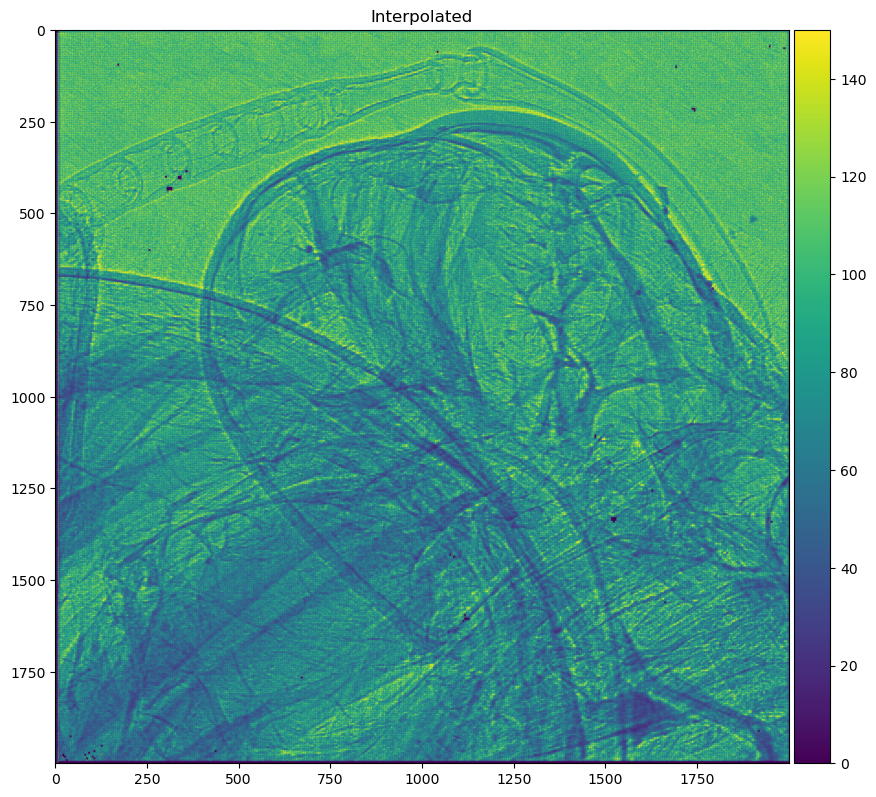

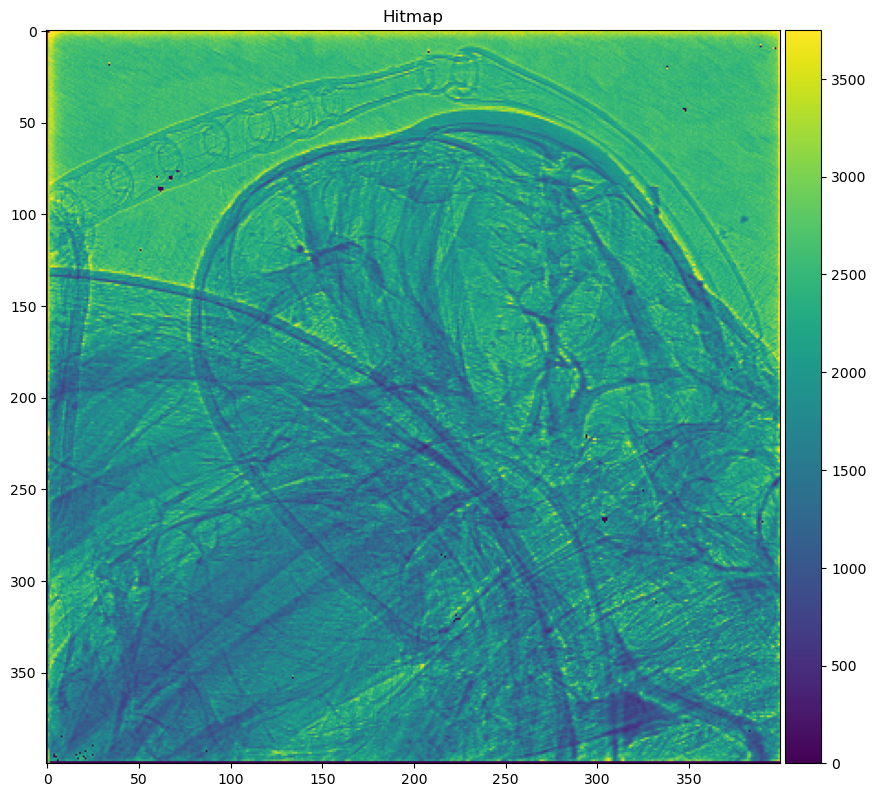

In [26]:
vis_index = 1
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(interpolated[:,:,vis_index])
im.set_clim(clim)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('Interpolated')

fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(hitmap[:,:,vis_index])
im.set_clim(clim*scale)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('Hitmap')